In [1]:
correction_list = {
    "Kim K": "Kim K.",
    "Al Ghareeb M.": "Al-Ghareeb M.",
    "Al Khulaifi N.G.": "Al-Khulaifi N.G.",
    "Alawadhi O.": "Al-Awadhi O.",
    "Bahrouzyan O.": "Al-Awadhi O.",
    "Haji A.": "Al-Haji A.",
    "Hajji A.": "Al-Haji A.",
    "El Aarej M.": "El-Aarej M.",
    "El Amrani R.": "El-Amrani R.",
    "El Aynaoui Y.": "El-Aynaoui Y.",
    "Granollers Pujol G.": "Granollers-Pujol G.",
    "Granollers G.": "Granollers-Pujol G.",
    "Granollers M.": "Granollers-Pujol M.",
    "Al Mutawa J.": "Ali Mutawa J.M.",
    "Al-Mutawa J.": "Ali Mutawa J.M.",
    "Bogomolov Jr. A.": "Bogomolov Jr.A.",
    "Bogomolov A.": "Bogomolov Jr.A.",
    "Carreno Busta": "Carreno-Busta",
    "Chela J.": "Chela J.I.",
    "Dutra Silva R.": "Dutra da Silva R.",
    "Dutra Da Silva R.": "Dutra da Silva R.",
    "Ferrero J.": "Ferrero J.C.",
    "Gambill J. M.": "Gambill J.M.",
    "Guzman J.": "Guzman J.P.",
    "Haider-Mauer A.": "Haider-Maurer A.",
    "Zayid M. S.": "Zayid M.S.",
    "De Bakker T.": "de Bakker T.",
    "De Chaunac S.": "de Chaunac S.",
    "De Greef A.": "de Greef A.",
    "De Heart R.": "de Heart R.",
    "De Loore J.": "de Loore J.",
    "De Minaur A.": "de Minaur A.",
    "De Schepper K.": "de Schepper K.",
    "De Voest R.": "de Voest R.",
    "Del Bonis F.": "del Bonis F.",
    "Del Potro J.": "del Potro J.M.",
    "Del Potro J. M.": "del Potro J.M.",
    "Del Potro J.M.": "del Potro J.M.",
    "Van D. Merwe I.": "van D. Merwe I.",
    "Van Der Merwe I.": "van Der Merwe I.",
    "Van Lottum J.": "van Lottum J.",
    "Van Rijthoven T.": "van Rijthoven T.",
    "Van der Dium A.": "van der Dium A.",
    "Van der Merwe I.": "van der Merwe I.",
    "Munoz De La Nava D.": "Munoz de la Nava D.",
    "Munoz de La Nava D.": "Munoz de la Nava D.",
    "Munoz-De La Nava D.": "Munoz de la Nava D.",
    "Di Mauro A.": "di Mauro A.",
    "Di Pasquale A.": "di Pasquale A.",
}

drop_list = ["W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5", "Wsets", "Lsets", "CBW", "CBL", "GBW", "GBL", "IWW", "IWL", "SBW", "SBL", "B&WW", "B&WL", "EXW", "EXL", "UBW", "UBL", "LBW", "LBL", "SJW", "SJL", "MaxW", "MaxL", "AvgW", "AvgL", "WRank", "LRank"]

Let's download, save, cleanup, and agregate the data into a dataframe and and save it to a csv file. We also caculate the elo rate of each player right before the game as well as the probability for the winner to win the game based on the elo rates of the two players.

In [20]:
import pandas as pd
import numpy as np
import requests
import io
import datetime

# Download the data
url_base = "http://tennis-data.co.uk/"

sess = requests.session()
df_list = []
for year in range(2000, 2013):
    url = f"{url_base}/{year}/{year}.xls"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xls", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))

for year in range(2013, datetime.datetime.now().year+1):
    url = f"{url_base}/{year}/{year}.xlsx"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xlsx", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))
sess.close()

# Put the downloaded data together
df_atp = pd.concat(df_list, axis=0).drop(labels=drop_list, axis=1) 

# Cleanup the data
df_atp["Winner"] = df_atp["Winner"].str.strip()
df_atp["Loser"] = df_atp["Loser"].str.strip()

df_atp["Winner"] = df_atp["Winner"].replace(correction_list)
df_atp["Loser"] = df_atp["Loser"].replace(correction_list)

df_atp["Best of"] = pd.to_numeric(df_atp["Best of"], errors="coerce", downcast="integer")
df_atp["WPts"] = pd.to_numeric(df_atp["WPts"], errors="coerce", downcast="integer")
df_atp["LPts"] = pd.to_numeric(df_atp["LPts"], errors="coerce", downcast="integer")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Calculate the elo rate and number of played matches for each player at the begining of the match.
# Also calculate the probability for the winner of the game to win the game based on the elo rates
elo_start = 1500.0
k_factor = 32.0

df_atp[["match_count_winner", "match_count_loser"]] = 0
df_atp[["elo_winner", "elo_loser"]] = elo_start
df_atp["proba_elo"] = .5

df_atp = df_atp.sort_values(by=["ATP", "Date"]).reset_index(drop=True).copy()

elo_rates = pd.DataFrame(data={"Player": pd.concat([df_atp["Winner"], df_atp["Loser"]], axis=0).unique(), "pts": 0, "match_count":  0, "elo": elo_start})
for index, _ in df_atp.iterrows():
    # Set atp points
    wpts = df_atp.loc[index, "WPts"]
    if np.isnan(wpts):
        df_atp.loc[index, "WPts"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "pts"].values[0]
    else:
        elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "pts"] = wpts
    
    lpts = df_atp.loc[index, "LPts"]
    if np.isnan(lpts):
        df_atp.loc[index, "LPts"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "pts"].values[0]
    else:
        elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "pts"] = lpts

    # Set the current elo rate/match count for the winner and loser of the match
    df_atp.loc[index, "elo_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"].values[0]
    df_atp.loc[index, "elo_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"].values[0]
    df_atp.loc[index, "match_count_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"].values[0]
    df_atp.loc[index, "match_count_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"].values[0]

    # Set the probability of the outcome based on the elo rates
    df_atp.loc[index, "proba_elo"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, "elo_loser"] - df_atp.loc[index, "elo_winner"])))

    # Update the elo scores/match counts based on the outcome of the match
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"] += k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"] -= k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"] += 1

# Save the result in respective files
df_atp.to_csv("archive/atp_data.csv")
elo_rates.to_csv("archive/elo_rates.csv")

Here, I add more features to the dataset, namely, match count and elo rates with respect to the specific court and surface type in which the game is played.

In [21]:
import pandas as pd
import numpy as np

# Load data from the disk
df_atp = pd.read_csv("archive/atp_data.csv", index_col=0)
elo_rates = pd.read_csv("archive/elo_rates.csv", index_col=0)

court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

try:
    elo_start
except NameError:
    elo_start = 1500.0
    k_factor = 32.0

# Initialize new columns in datasets
for pair in court_surface_type:
    col_name = f"{pair[0].lower()}_{pair[1].lower()}"
    df_atp[[f"match_count_{col_name}_winner", f"match_count_{col_name}_loser"]] = 0
    df_atp[[f"elo_{col_name}_winner", f"elo_{col_name}_loser"]] = elo_start
    df_atp[f"proba_elo_{col_name}"] = .5
    

    elo_rates[f"match_count_{col_name}"] = 0
    elo_rates[f"elo_{col_name}"] = elo_start

# Add the field specific elo rates and played match count of the players
for index, _ in df_atp.iterrows():
    field_type = f"{df_atp.loc[index, 'Court'].lower()}_{df_atp.loc[index, 'Surface'].lower()}"
    for pair in court_surface_type:
        col_name = f"{pair[0].lower()}_{pair[1].lower()}"

        # Set the current match count for the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"match_count_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{col_name}"].values[0]
        df_atp.loc[index, f"match_count_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{col_name}"].values[0]

        # Set the current elo rate of the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"elo_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{col_name}"].values[0]
        df_atp.loc[index, f"elo_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{col_name}"].values[0]
        
        # Set the probability of the outcome based on the elo rates (court/surface specific)
        df_atp.loc[index, f"proba_elo_{col_name}"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, f"elo_{col_name}_loser"] - df_atp.loc[index, f"elo_{col_name}_winner"])))
    
    # Update match counts based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{field_type}"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{field_type}"] += 1

    # Update elo rates based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{field_type}"] += k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{field_type}"] -= k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])

# Save the new dataset (enriched dataset)
df_atp.to_csv("archive/atp_data_enriched.csv")
elo_rates.to_csv("archive/elo_rates_enriched.csv")

# Show its info
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64265 entries, 0 to 64264
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ATP                               64265 non-null  int64  
 1   Location                          64265 non-null  object 
 2   Tournament                        64265 non-null  object 
 3   Date                              64265 non-null  object 
 4   Series                            64265 non-null  object 
 5   Court                             64265 non-null  object 
 6   Surface                           64265 non-null  object 
 7   Round                             64265 non-null  object 
 8   Best of                           64250 non-null  float64
 9   Winner                            64265 non-null  object 
 10  Loser                             64265 non-null  object 
 11  Comment                           64265 non-null  object 
 12  B365W    

In [22]:
elo_rates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620 entries, 0 to 1619
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     1620 non-null   object 
 1   pts                        1620 non-null   int64  
 2   match_count                1620 non-null   int64  
 3   elo                        1620 non-null   float64
 4   match_count_indoor_hard    1620 non-null   int64  
 5   elo_indoor_hard            1620 non-null   float64
 6   match_count_indoor_carpet  1620 non-null   int64  
 7   elo_indoor_carpet          1620 non-null   float64
 8   match_count_indoor_clay    1620 non-null   int64  
 9   elo_indoor_clay            1620 non-null   float64
 10  match_count_outdoor_hard   1620 non-null   int64  
 11  elo_outdoor_hard           1620 non-null   float64
 12  match_count_outdoor_clay   1620 non-null   int64  
 13  elo_outdoor_clay           1620 non-null   float64
 1

One can read all datasets directly from the disk and avoid doing the time consuming processing

In [23]:
import pandas as pd

# Load data from the disk
elo_rates = pd.read_csv("archive/elo_rates_enriched.csv", index_col=0)
df_atp = pd.read_csv("archive/atp_data_enriched.csv", index_col=0)
# df_conf = pd.read_csv("archive/confidence_data.csv")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Drop 350 rows where bet odds are absent
# We just ignore the odds for losers cause they do not appear in our futher analysis.
df_atp_reduced = df_atp.dropna(subset=["PSW", "B365W"], axis=0)

# Show the info i deletes 15 columns with NaN
df_atp_clean = df_atp_reduced.dropna()

# new data frame df_atp_clean with only the inital22 atributes
# Drop columns after the 22nd column
df_atp_clean = df_atp_clean.iloc[:, :23]

# Save dataframes on the disk
df_atp_clean.to_csv("archive/df_atp_clean.csv")
df_atp_reduced.to_csv("archive/df_atp_reduced.csv")

# Display the first few rows to verify the changes
df_atp_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48809 entries, 125 to 64141
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ATP                 48809 non-null  int64         
 1   Location            48809 non-null  object        
 2   Tournament          48809 non-null  object        
 3   Date                48809 non-null  datetime64[ns]
 4   Series              48809 non-null  object        
 5   Court               48809 non-null  object        
 6   Surface             48809 non-null  object        
 7   Round               48809 non-null  object        
 8   Best of             48809 non-null  float64       
 9   Winner              48809 non-null  object        
 10  Loser               48809 non-null  object        
 11  Comment             48809 non-null  object        
 12  B365W               48809 non-null  float64       
 13  B365L               48809 non-null  float64      

In [24]:
df_atp_reduced.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,match_count_outdoor_clay_winner,match_count_outdoor_clay_loser,elo_outdoor_clay_winner,elo_outdoor_clay_loser,proba_elo_outdoor_clay,match_count_outdoor_grass_winner,match_count_outdoor_grass_loser,elo_outdoor_grass_winner,elo_outdoor_grass_loser,proba_elo_outdoor_grass
64230,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Djokovic N.,...,327,54,1945.836747,1548.326690,0.907899,128,60,2031.642431,1669.640108,0.889324
64231,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Rublev A.,...,100,123,1690.460706,1807.273558,0.337953,27,35,1625.000143,1597.077705,0.540097
64232,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Djokovic N.,...,327,64,1945.836747,1568.776712,0.897572,128,44,2031.642431,1571.271783,0.934018
64233,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Ruud C.,...,175,100,1769.315045,1690.460706,0.611571,12,27,1454.898202,1625.000143,0.273053
64234,68,Turin,Masters Cup,2022-11-20,Masters Cup,Indoor,Hard,The Final,NaN,Djokovic N.,...,327,175,1945.836747,1769.315045,0.734220,128,12,2031.642431,1454.898202,0.965109


# Get a sense of the bet odds:

In [25]:
df_atp_reduced[["PSW", "PSL", "B365W", "B365L"]].describe()

,PSW,PSL,B365W,B365L
count,48824.000000,48824.000000,48824.000000,48824.000000
mean,1.926517,4.027414,1.835885,3.523212
std,1.283004,5.101693,1.125413,3.498574
min,0.972000,1.010000,0.971000,0.967000
25%,1.280000,1.781000,1.250000,1.720000
50%,1.560000,2.610000,1.500000,2.500000
75%,2.150000,4.130000,2.100000,3.750000
max,46.000000,121.000000,34.000000,101.000000


In [26]:
elo_rates.describe()

,pts,match_count,elo,match_count_indoor_hard,elo_indoor_hard,match_count_indoor_carpet,elo_indoor_carpet,match_count_indoor_clay,elo_indoor_clay,match_count_outdoor_hard,elo_outdoor_hard,match_count_outdoor_clay,elo_outdoor_clay,match_count_outdoor_grass,elo_outdoor_grass
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,360.335185,79.339506,1500.000000,11.795062,1500.000000,2.091358,1500.000000,0.400000,1500.000000,31.255556,1500.000000,25.016049,1500.000000,8.781481,1500.000000
std,615.856231,162.771019,85.518408,27.425411,49.727443,7.041678,21.661579,1.838239,8.542529,67.851481,71.826174,55.596144,64.823390,19.106584,50.957042
min,0.000000,1.000000,1317.880295,0.000000,1361.509081,0.000000,1397.458084,0.000000,1416.600077,0.000000,1269.104134,0.000000,1335.193473,0.000000,1335.573562
25%,6.000000,2.000000,1461.131502,0.000000,1484.000000,0.000000,1500.000000,0.000000,1500.000000,0.000000,1471.766247,0.000000,1477.130321,0.000000,1484.000000
50%,164.500000,8.000000,1483.142442,1.000000,1500.000000,0.000000,1500.000000,0.000000,1500.000000,2.000000,1500.000000,2.000000,1500.000000,1.000000,1500.000000
75%,442.250000,75.250000,1505.144710,8.000000,1500.000000,0.000000,1500.000000,0.000000,1500.000000,25.000000,1500.000000,22.000000,1500.000000,8.000000,1500.000000
max,6730.000000,1442.000000,2023.533760,251.000000,1944.955620,69.000000,1743.530935,22.000000,1625.072438,638.000000,2150.268703,500.000000,2114.770659,213.000000,2031.642431


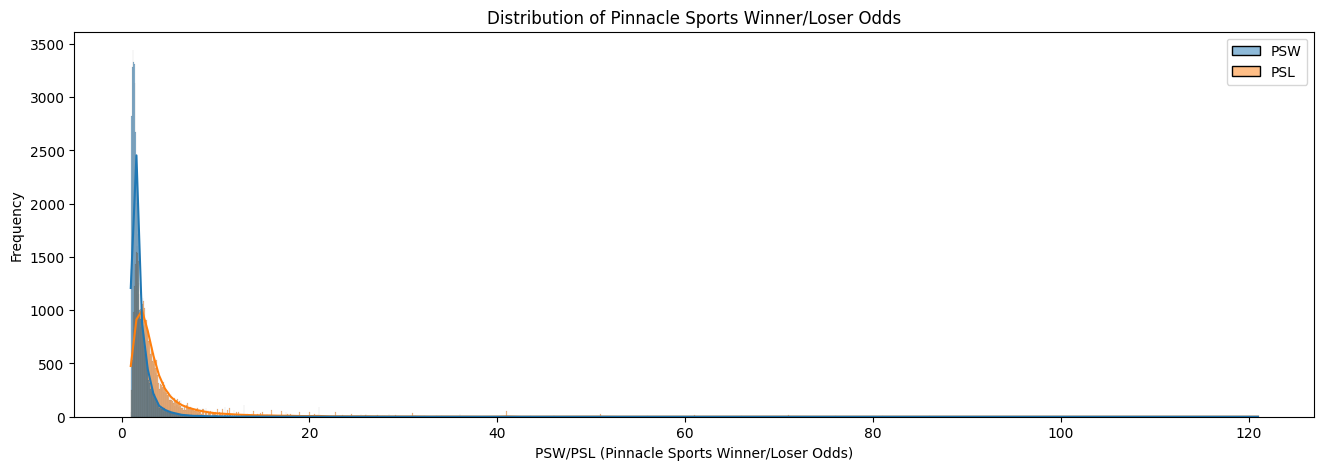

They max on 46.0 (for winners) and 121.0 (for losers).


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp_reduced[["PSW", "PSL"]], kde=True, color=[["green"], ["red"]])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['PSW'].max()} (for winners) and {df_atp_reduced['PSL'].max()} (for losers).")

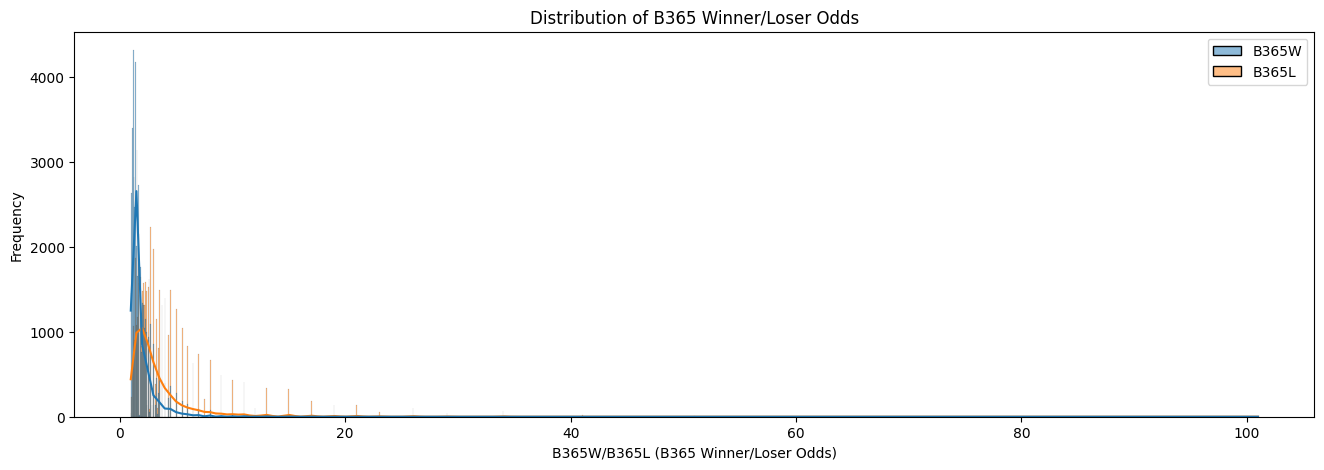

They max on 34.0 (for winners) and 101.0 (for losers).


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp_reduced[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['B365W'].max()} (for winners) and {df_atp_reduced['B365L'].max()} (for losers).")

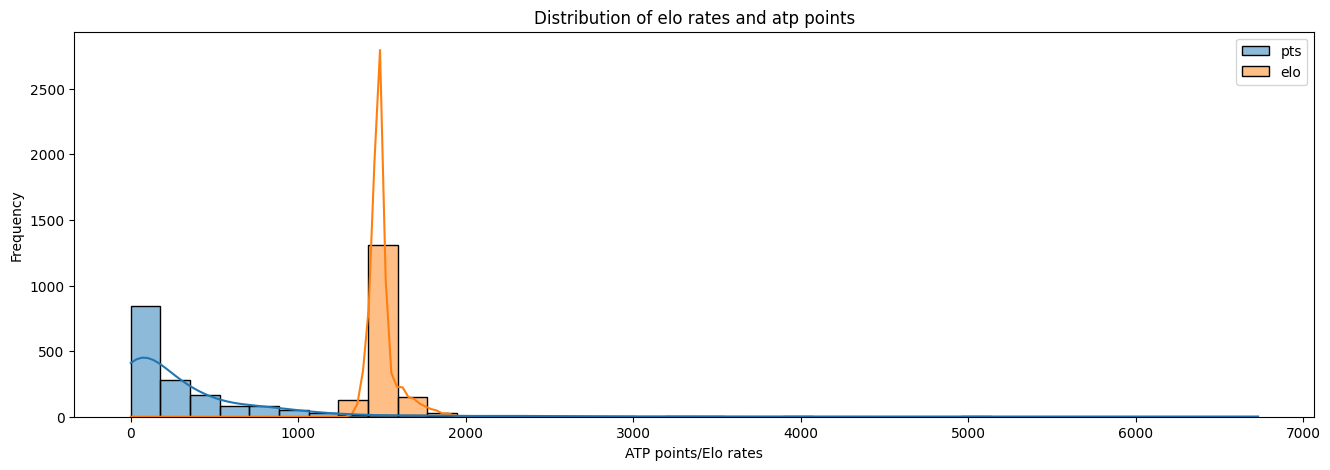

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(elo_rates[["pts", "elo"]], kde=True, color=[["green"], ["red"]])

# Add labels and title
plt.title('Distribution of elo rates and atp points')
plt.xlabel('ATP points/Elo rates')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Top 10 players over all (without considering the field type):

In [32]:
print(f"Top 10 players over all (without considering the field type):")
elo_rates[["Player", "match_count", "elo"]].sort_values(by="elo", ascending=False).iloc[:10]

Top 10 players over all (without considering the field type):


,Player,match_count,elo
84,Djokovic N.,1243,2023.533760
3,Federer R.,1442,1986.283342
80,Murray A.,952,1942.006366
446,Nalbandian D.,541,1927.281010
8,Hewitt L.,727,1900.511043
199,Sinner J.,261,1893.736024
204,Rune H.,158,1893.066622
427,Alcaraz C.,195,1888.501658
85,del Potro J.M.,587,1883.038642
127,Dimitrov G.,682,1875.479290


# Top 10 players in indoor courts and on hard surfaces:

In [33]:
court_surface_type = df_atp_reduced[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

index = 0
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on hard surfaces:


,Player,match_count_indoor_hard,elo_indoor_hard
84,Djokovic N.,193,1944.955620
3,Federer R.,251,1882.985837
80,Murray A.,164,1865.666482
204,Rune H.,47,1803.831300
85,del Potro J.M.,115,1802.242296
446,Nalbandian D.,63,1775.490970
127,Dimitrov G.,137,1768.026102
482,Zverev A.,104,1758.489887
199,Sinner J.,73,1755.745030
98,Soderling R.,116,1740.751907


# Top 10 players in indoor courts and on carpet surfaces:

In [34]:
index = 1
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on carpet surfaces:


,Player,match_count_indoor_carpet,elo_indoor_carpet
446,Nalbandian D.,45,1743.530935
448,Safin M.,64,1725.213894
3,Federer R.,60,1678.953410
370,Kafelnikov Y.,37,1669.796325
38,Davydenko N.,57,1664.012327
7,Henman T.,37,1659.057469
80,Murray A.,24,1645.667525
98,Soderling R.,29,1643.943041
233,Youzhny M.,62,1640.301804
106,Roddick A.,36,1632.421053


# Top 10 players in indoor courts and on clay surfaces:

In [35]:
index = 2
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on clay surfaces:


,Player,match_count_indoor_clay,elo_indoor_clay
325,Cuevas P.,19,1625.072438
321,Jarry N.,12,1578.487585
320,Pella G.,14,1573.177593
479,Garin C.,14,1571.159831
152,Nadal R.,4,1567.504325
516,Ruud C.,10,1563.889683
181,Fognini F.,11,1563.143787
446,Nalbandian D.,8,1561.387034
730,Seyboth Wild T.,10,1554.128924
480,Delbonis F.,22,1552.233578


# Top 10 players in outdoor courts and on hard surfaces:

In [36]:
index = 3
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on hard surfaces:


,Player,match_count_outdoor_hard,elo_outdoor_hard
84,Djokovic N.,582,2150.268703
3,Federer R.,638,2065.545468
80,Murray A.,478,1939.811708
152,Nadal R.,535,1936.510644
161,Medvedev D.,222,1890.582531
541,Sampras P.,91,1875.729444
427,Alcaraz C.,84,1867.604565
85,del Potro J.M.,295,1861.554435
199,Sinner J.,104,1859.818892
535,Agassi A.,207,1853.118641


# Top 10 players in outdoor courts and on clay surfaces:

In [37]:
index = 4
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on clay surfaces:


,Player,match_count_outdoor_clay,elo_outdoor_clay
152,Nadal R.,500,2114.770659
84,Djokovic N.,327,1945.836747
80,Murray A.,151,1932.826518
427,Alcaraz C.,73,1858.455370
85,del Potro J.M.,112,1849.828203
100,Nishikori K.,151,1832.345763
3,Federer R.,280,1819.657570
318,Tsitsipas S.,123,1807.273558
98,Soderling R.,120,1806.470828
451,Kuerten G.,145,1797.159425


# Top 10 players in outdoor courts and on grass surfaces:

In [38]:
index = 5
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on grass surfaces:


,Player,match_count_outdoor_grass,elo_outdoor_grass
84,Djokovic N.,128,2031.642431
3,Federer R.,213,1983.267325
152,Nadal R.,97,1843.355226
80,Murray A.,135,1829.604428
130,Cilic M.,110,1819.177954
106,Roddick A.,103,1767.299838
72,Berdych T.,98,1766.786125
139,Raonic M.,74,1754.255720
8,Hewitt L.,134,1749.842855
94,Tsonga J.W.,72,1747.980698


It's time to define some betting strategies:

1. To bet on the higher ranked player (HPBS)
2. To bet on the lower ranked player (LPBS)
3. To bet on the player with higher total elo rate (HRBS)
4. To bet on the player with lower total elo rate (LRBS)
5. To bet on the player with the better elo rate in the appropirate field type (BRFTBS)
6. To bet on a random player (RPBS)
7. To bet on the winner always (WBS)
8. To bet on the loser always (LBS)

Ofcourse, the strategies 7 and 8 are just theoretical and put there to compare the strategies with the theoretical maximum profit/loss.

In [39]:
import numpy as np

profit = df_atp_reduced[["Court", "Surface", "Winner", "Loser", "WPts", "LPts", "PSW", "B365W", "proba_elo", "proba_elo_indoor_hard", "proba_elo_indoor_clay", "proba_elo_indoor_carpet", "proba_elo_outdoor_hard", "proba_elo_outdoor_clay", "proba_elo_outdoor_grass"]].copy()

# Strategy 1
strategies = pd.DataFrame(df_atp["WPts"] > df_atp["LPts"], columns=["HPBS"], index=df_atp_reduced.index)
profit[["HPBS_PS", "HPBS_B365"]] = profit.loc[strategies["HPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HPBS_PS", "B365W": "HPBS_B365"}) - 1.0

# Strategy 2
strategies["LPBS"] = df_atp["WPts"] < df_atp["LPts"]
profit[["LPBS_PS", "LPBS_B365"]] = profit.loc[strategies["LPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LPBS_PS", "B365W": "LPBS_B365"}) - 1.0

# Strategy 3
strategies["HRBS"] = df_atp["elo_winner"] > df_atp["elo_loser"]
profit[["HRBS_PS", "HRBS_B365"]] = profit.loc[strategies["HRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HRBS_PS", "B365W": "HRBS_B365"}) - 1.0

# Strategy 4
strategies["LRBS"] = df_atp["elo_winner"] < df_atp["elo_loser"]
profit[["LRBS_PS", "LRBS_B365"]] = profit.loc[strategies["LRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LRBS_PS", "B365W": "LRBS_B365"}) - 1.0

# Strategy 5
court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()
strategies["BRFTBS"] = False
for pair in court_surface_type:
    col_name = f"proba_elo_{pair[0].lower()}_{pair[1].lower()}"
    strategies.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), "BRFTBS"] = profit.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), col_name] >= .5
profit[["BRFTBS_PS", "BRFTBS_B365"]] = profit.loc[strategies["BRFTBS"], ["PSW", "B365W"]].rename(columns={"PSW": "BRFTBS_PS", "B365W": "BRFTBS_B365"}) - 1.0

# Strategy 6
np.random.seed(13572)
strategies["RPBS"] = np.random.randint(0, 2, size=len(strategies))==1
profit[["RPBS_PS", "RPBS_B365"]] = profit.loc[strategies["RPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "RPBS_PS", "B365W": "RPBS_B365"}) - 1.0

# Strategy 7
strategies["WBS"] = True
profit[["WBS_PS", "WBS_B365"]] = profit.loc[strategies["WBS"], ["PSW", "B365W"]].rename(columns={"PSW": "WBS_PS", "B365W": "WBS_B365"}) - 1.0

# Strategy 8
strategies["LBS"] = False
profit[["LBS_PS", "LBS_B365"]] = profit.loc[strategies["LBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LBS_PS", "B365W": "LBS_B365"}) - 1.0

# profit.dropna(axis=0, subset=["PSW", "B365W"], inplace=True)
profit.fillna(value=-1.0, inplace=True)

profit.head(10)

,Court,Surface,Winner,Loser,WPts,LPts,PSW,B365W,proba_elo,proba_elo_indoor_hard,...,LRBS_PS,LRBS_B365,BRFTBS_PS,BRFTBS_B365,RPBS_PS,RPBS_B365,WBS_PS,WBS_B365,LBS_PS,LBS_B365
125,Outdoor,Hard,Dent T.,Horna L.,0.0,0.0,1.241,1.160,0.500000,0.5,...,-1.000,-1.000,0.241,0.160,0.241,0.160,0.241,0.160,-1.0,-1.0
126,Outdoor,Hard,Martin A.,Ancic M.,0.0,0.0,2.170,2.000,0.598188,0.5,...,-1.000,-1.000,1.170,1.000,1.170,1.000,1.170,1.000,-1.0,-1.0
127,Outdoor,Hard,Beck K.,Vahaly B.,0.0,0.0,1.730,1.830,0.455081,0.5,...,0.730,0.830,-1.000,-1.000,0.730,0.830,0.730,0.830,-1.0,-1.0
128,Outdoor,Hard,Nieminen J.,Moodie W.,0.0,0.0,1.459,1.400,0.500000,0.5,...,-1.000,-1.000,0.459,0.400,0.459,0.400,0.459,0.400,-1.0,-1.0
130,Outdoor,Hard,Arthurs W.,Karlovic I.,0.0,0.0,1.862,1.800,0.439260,0.5,...,0.862,0.800,-1.000,-1.000,-1.000,-1.000,0.862,0.800,-1.0,-1.0
131,Outdoor,Hard,Sanguinetti D.,Elsner D.,0.0,0.0,1.699,1.800,0.500000,0.5,...,-1.000,-1.000,0.699,0.800,0.699,0.800,0.699,0.800,-1.0,-1.0
133,Outdoor,Hard,Hrbaty D.,Benneteau J.,0.0,0.0,1.592,1.533,0.476990,0.5,...,0.592,0.533,-1.000,-1.000,0.592,0.533,0.592,0.533,-1.0,-1.0
134,Outdoor,Hard,Clement A.,Hanescu V.,0.0,0.0,1.526,1.444,0.479057,0.5,...,0.526,0.444,-1.000,-1.000,0.526,0.444,0.526,0.444,-1.0,-1.0
135,Outdoor,Hard,Llodra M.,Burgsmuller L.,0.0,0.0,1.676,1.615,0.500000,0.5,...,-1.000,-1.000,0.676,0.615,0.676,0.615,0.676,0.615,-1.0,-1.0
136,Outdoor,Hard,Saulnier C.,Ginepri R.,0.0,0.0,2.700,2.625,0.500000,0.5,...,-1.000,-1.000,1.700,1.625,-1.000,-1.000,1.700,1.625,-1.0,-1.0


# This is how each strategy would perform on "Pinnacle Sports":

In [40]:
print("The statistics related to bet strategies on \"Pinnacle Sports\"")
profit[["HPBS_PS", "LPBS_PS", "HRBS_PS", "LRBS_PS", "BRFTBS_PS", "RPBS_PS", "WBS_PS", "LBS_PS"]].describe()

The statistics related to bet strategies on "Pinnacle Sports"


,HPBS_PS,LPBS_PS,HRBS_PS,LRBS_PS,BRFTBS_PS,RPBS_PS,WBS_PS,LBS_PS
count,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.0
mean,-0.034007,-0.048112,-0.003532,-0.072703,0.006228,-0.031748,0.926517,-1.0
std,0.817847,1.681380,0.876159,1.652642,0.927759,1.324766,1.283004,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.028000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.280000,-1.0
50%,0.180000,-1.000000,0.180000,-1.000000,0.170000,0.010000,0.560000,-1.0
75%,0.474000,0.790000,0.500000,0.700000,0.510000,0.570000,1.150000,-1.0
max,11.000000,45.000000,14.000000,45.000000,20.000000,45.000000,45.000000,-1.0


# This is how each strategy would perform on "Bet 365":

In [41]:
print("The statistics related to bet strategies on \"Bet 365\"")
profit[["HPBS_B365", "LPBS_B365", "HRBS_B365", "LRBS_B365", "BRFTBS_B365", "RPBS_B365", "WBS_B365", "LBS_B365"]].describe()

The statistics related to bet strategies on "Bet 365"


,HPBS_B365,LPBS_B365,HRBS_B365,LRBS_B365,BRFTBS_B365,RPBS_B365,WBS_B365,LBS_B365
count,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.000000,48824.0
mean,-0.066570,-0.105479,-0.038419,-0.128323,-0.029282,-0.076446,0.835885,-1.0
std,0.832469,1.502322,0.880413,1.473839,0.923185,1.217068,1.125413,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.029000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.250000,-1.0
50%,0.140000,-1.000000,0.140000,-1.000000,0.140000,0.002000,0.500000,-1.0
75%,0.400000,0.720000,0.440000,0.610000,0.440000,0.500000,1.100000,-1.0
max,33.000000,28.000000,33.000000,28.000000,33.000000,33.000000,33.000000,-1.0


Summary of the strategies:
- The self-defined variable -field specific Elo rate- is suprisingly the most relevant variable among the ones we defined.
- Except strategy 5 (To bet on the player with the better elo rate in the appropriate field type (BRFTBS)), all betting strategies perform poorly.
- This low marginal profit (in case of BRFTBS on PS) can turn up negative by choosing an arbitrary sub set of the matches, which means losing money.
- Even in the best case senario, his low margin of profit is increases the risk of losing money.
- Therefore, we have to come up with new betting strategies, to gain some money.

To beat bookmakers, we used ML to predict matches as accurate as possible. Algorithms:
- Random Forest
- Decision tree with Ada boost
- Support Vector Machine
- Voting algorithm combining above-mentioned algorithms
- Neural Network

# Constructing the feature set:

In [44]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import joblib

# Load from disk
df_atp_reduced = pd.read_csv("archive/df_atp_reduced.csv", index_col=0)

# Each cell in the dataframe features answers to the question whether the specified strategy predicts that player one wins
# Before constructing the dataframe we should scramble the players so that sometimes player 1 wins and he loses the other times with equal probabilities.
court_surface_type = df_atp_reduced[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

np.random.seed(98245)
features = pd.DataFrame(np.random.randint(0, 2, size=len(df_atp_reduced))==1, columns=["P1==Winner"], index=df_atp_reduced.index)

features["P1_wins_proba_elo"] = ((1.0 - features["P1==Winner"]) - df_atp_reduced["proba_elo"]).abs()
features["P1_match_count"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], "match_count_winner"], df_atp_reduced.loc[~features["P1==Winner"], "match_count_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P2_match_count"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], "match_count_winner"], df_atp_reduced.loc[features["P1==Winner"], "match_count_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P1_pts"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], "WPts"], df_atp_reduced.loc[~features["P1==Winner"], "LPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
features["P2_pts"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], "WPts"], df_atp_reduced.loc[features["P1==Winner"], "LPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")

for pair in court_surface_type:
    field_type = f"{pair[0].lower()}_{pair[1].lower()}"
    features[f"field_type=={field_type}"] = (df_atp_reduced["Court"].str.lower() + "_" + df_atp_reduced["Surface"].str.lower() == field_type) + 0
    features[f"P1_match_count_{field_type}"] = pd.merge(df_atp_reduced.loc[features["P1==Winner"], f"match_count_{field_type}_winner"], df_atp_reduced.loc[~features["P1==Winner"], f"match_count_{field_type}_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features[f"P2_match_count_{field_type}"] = pd.merge(df_atp_reduced.loc[~features["P1==Winner"], f"match_count_{field_type}_winner"], df_atp_reduced.loc[features["P1==Winner"], f"match_count_{field_type}_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features[f"P1_wins_proba_elo_{field_type}"] = ((1.0 - features["P1==Winner"]) - df_atp_reduced[f"proba_elo_{field_type}"]).abs()
    
target = features["P1==Winner"]
data = features.drop(labels=["P1==Winner"], axis=1)

scaler = sklearn.preprocessing.StandardScaler()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index), target, test_size=0.2, random_state=4362)

# Save the scaler on the disk
joblib.dump(value=scaler, filename="archive/scaler.pkl")

# Back up the different dataframes
data.to_csv("archive/data.csv")
target.to_csv("archive/target.csv")

features.tail()

,P1==Winner,P1_wins_proba_elo,P1_match_count,P2_match_count,P1_pts,P2_pts,field_type==indoor_hard,P1_match_count_indoor_hard,P2_match_count_indoor_hard,P1_wins_proba_elo_indoor_hard,...,P2_match_count_outdoor_hard,P1_wins_proba_elo_outdoor_hard,field_type==outdoor_clay,P1_match_count_outdoor_clay,P2_match_count_outdoor_clay,P1_wins_proba_elo_outdoor_clay,field_type==outdoor_grass,P1_match_count_outdoor_grass,P2_match_count_outdoor_grass,P1_wins_proba_elo_outdoor_grass
64230,True,0.747208,1240,444,3320,4065,1,190,108,0.797799,...,222,0.816809,0,327,54,0.907899,0,128,60,0.889324
64231,False,0.698105,419,425,5350,3530,1,98,100,0.699974,...,198,0.530224,0,123,100,0.662047,0,35,27,0.459903
64232,True,0.863949,1241,379,3320,2955,1,191,51,0.890318,...,220,0.937717,0,327,64,0.897572,0,128,44,0.934018
64233,True,0.367337,322,426,5020,3530,1,29,101,0.377166,...,198,0.341274,0,175,100,0.611571,0,12,27,0.273053
64234,False,0.118394,323,1242,5020,3320,1,30,192,0.102216,...,582,0.043775,0,175,327,0.265780,0,12,128,0.034891


In [45]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48824 entries, 125 to 64234
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   P1==Winner                       48824 non-null  bool   
 1   P1_wins_proba_elo                48824 non-null  float64
 2   P1_match_count                   48824 non-null  int64  
 3   P2_match_count                   48824 non-null  int64  
 4   P1_pts                           48824 non-null  int64  
 5   P2_pts                           48824 non-null  int64  
 6   field_type==indoor_hard          48824 non-null  int64  
 7   P1_match_count_indoor_hard       48824 non-null  int64  
 8   P2_match_count_indoor_hard       48824 non-null  int64  
 9   P1_wins_proba_elo_indoor_hard    48824 non-null  float64
 10  field_type==indoor_carpet        48824 non-null  int64  
 11  P1_match_count_indoor_carpet     48824 non-null  int64  
 12  P2_match_count_indoor

# Random Forest Classifier:

A grid search to find the optimum hyperparameters for random forest:

In [6]:
import sklearn.ensemble
import sklearn.model_selection
import joblib

# Create and train grid model on Random Forest
grid_rf = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestClassifier(), param_grid={"max_depth" : range(10, 20), "random_state" : [26895645], "max_features": ["sqrt", "log2", None], "min_samples_split": range(2, 31)}, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_rf, filename="archive/grid_rf.pkl")

grid_rf.best_params_
# print({"max_depth": 14, "max_features": "log2", "min_samples_split": 27, "random_state": 26895645})

{'max_depth': 14,
 'max_features': 'log2',
 'min_samples_split': 27,
 'random_state': 26895645}

In [7]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_rfc = sklearn.ensemble.RandomForestClassifier(max_depth=14, max_features="log2", min_samples_split=27, random_state=26895645, n_jobs=-1)
model_rfc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_rfc, filename="archive/model_rfc.pkl")

rfc_result = pd.DataFrame({"rfc_result": ~np.logical_xor(model_rfc.predict(X_test), y_test), "rfc_proba_P1_wins": model_rfc.predict_proba(X_test)[:, 1]}, index=y_test.index)

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

print(f"Random forest with the given features can predict correctly with the probability of {round(model_rfc.score(X_test, y_test)*100, 2)} %")
profits_test[["rfc_result", "rfc_certainty", "rfc_profit_PS", "rfc_profit_B365"]] = pd.DataFrame({"rfc_result": 0 + rfc_result["rfc_result"], "rfc_certainty": 2*(rfc_result["rfc_proba_P1_wins"] - .5).abs(), "rfc_profit_PS": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "rfc_profit_B365": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Random forest with the given features can predict correctly with the probability of 66.93 %


# Decision Tree Classifier with Ada Boost:

A grid search to find the optimum hyperparameters for Ada boost (on decision tree):

In [4]:
import sklearn.model_selection
import sklearn.ensemble
import numpy as np
import joblib

# Create and train grid model on Ada boost (on decision tree)
grid_dtc_abc = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.AdaBoostClassifier(), param_grid={"estimator": [sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth=3), sklearn.tree.DecisionTreeClassifier(criterion="gini", max_depth=3)], "learning_rate": np.power(10.0, np.arange(-3, 0, .5)), "n_estimators": range(100, 1001, 100), "algorithm": ["SAMME"], "random_state": [26645]}, n_jobs=-1)
grid_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_dtc_abc, filename="archive/grid_dtc_abc.pkl")

grid_dtc_abc.best_params_
# print({'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 26645})

{'algorithm': 'SAMME',
 'estimator': DecisionTreeClassifier(max_depth=3),
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'random_state': 26645}

In [8]:
import pandas as pd
import numpy as np
import sklearn.tree
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_dtc = sklearn.tree.DecisionTreeClassifier(max_depth=3)
model_dtc_abc = sklearn.ensemble.AdaBoostClassifier(estimator=model_dtc, learning_rate=1e-1, n_estimators=1000, algorithm="SAMME", random_state=26645)
model_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_dtc_abc, filename="archive/model_dtc_abc.pkl")

dtc_abc_result = pd.DataFrame({"dtc_abc_result": ~np.logical_xor(model_dtc_abc.predict(X_test), y_test), "dtc_abc_proba_P1_wins": model_dtc_abc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of {round(model_dtc_abc.score(X_test, y_test)*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["dtc_abc_result", "dtc_abc_certainty", "dtc_abc_profit_PS", "dtc_abc_profit_B365"]] = pd.DataFrame({"dtc_abc_result": 0 + dtc_abc_result["dtc_abc_result"], "dtc_abc_certainty": 2*(dtc_abc_result["dtc_abc_proba_P1_wins"] - .5).abs(), "dtc_abc_profit_PS": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "dtc_abc_profit_B365": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of 67.38 %


# Support Vector Classifier:

A grid search to find the optimum hyperparameters for svm:

In [4]:
import sklearn.svm
import sklearn.model_selection
import joblib

# Create and train grid model on svm
grid_svm = sklearn.model_selection.GridSearchCV(estimator=sklearn.svm.SVC(), param_grid={"kernel" : ["rbf", "linear", "poly", "sigmoid"], "C" : [.1, 1.0, 10.0, 50.0], "random_state": [9274]}, n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_svm, filename="archive/grid_svm.pkl")

grid_svm.best_params_
# print({"C": 1.0, "kernel": "rbf", "random_state": 9274})

{'C': 1.0, 'kernel': 'rbf', 'random_state': 9274}

In [149]:
import pandas as pd
import numpy as np
import sklearn.svm
import joblib

# Create and fit the model with the optimum hyperparameters
model_svm = sklearn.svm.SVC(kernel="rbf", C=1.0, probability=True, random_state=9274)
model_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_svm, filename="archive/model_svm.pkl")

svm_result = pd.DataFrame({"svm_result": ~np.logical_xor(model_svm.predict(X_test), y_test), "svm_proba_P1_wins": model_svm.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"SVM with the given features can predict correctly with the probability of {round(model_svm.score(X_test, y_test)*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["svm_result", "svm_certainty", "svm_profit_PS", "svm_profit_B365"]] = pd.DataFrame({"svm_result": 0 + svm_result["svm_result"], "svm_certainty": 2*(svm_result["svm_proba_P1_wins"] - .5).abs(), "svm_profit_PS": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "svm_profit_B365": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

SVM with the given features can predict correctly with the probability of 67.15 %


In [19]:
import sklearn.ensemble
import joblib

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

accuracies = profits_test[["rfc_result", "dtc_abc_result", "svm_result"]].mean(axis=0).to_numpy()

# Create and fit the voting model
model_vc = sklearn.ensemble.VotingClassifier(estimators=[("rfc", model_rfc), ("dtc_abc", model_dtc_abc), ("svc", model_svm)], weights=accuracies, voting="soft", n_jobs=-1)
model_vc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_vc, filename="archive/model_vc.pkl")

vc_result = pd.DataFrame({"vc_result": ~np.logical_xor(model_vc.predict(X_test), y_test), "vc_proba_P1_wins": model_vc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Voting classifier with the given features can predict correctly with the probability of {round(model_vc.score(X_test, y_test)*100, 2)} %")

profits_test[["vc_result", "vc_certainty", "vc_profit_PS", "vc_profit_B365"]] = pd.DataFrame({"vc_result": 0 + vc_result["vc_result"], "vc_certainty": 2*(vc_result["vc_proba_P1_wins"] - .5).abs(), "vc_profit_PS": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "vc_profit_B365": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Voting classifier with the given features can predict correctly with the probability of 67.27 %


# Neural Network Classifier:

In [17]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.models.Sequential()

# Add layers to the model
model_nn.add(tf.keras.layers.Dense(40, input_dim=29, activation='relu'))    # Input layer with 29 features
model_nn.add(tf.keras.layers.Dense(25, activation='relu'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(10, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(5, activation='sigmoid'))                # Hidden layer
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))                # Output layer with sigmoid activation for binary classification

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
# model_nn.summary()

# Fit the model
history = model_nn.fit(X_train, y_train + 0.0, epochs=35, batch_size=4096, validation_data=(X_test, y_test))

# Save the model on disk
model_nn.save("archive/model_nn.keras")

nn_result = pd.DataFrame({"nn_result": ~np.logical_xor(model_nn.predict(X_test)[:, 0]>.5, y_test), "nn_proba_P1_wins": model_nn.predict(X_test)[:, 0]}, index=y_test.index)
print(f"Neural network algorithm with the given features can predict correctly with the probability of {round(model_nn.evaluate(X_test, y_test)[1]*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["nn_result", "nn_certainty", "nn_profit_PS", "nn_profit_B365"]] = pd.DataFrame({"nn_result": 0 + nn_result["nn_result"], "nn_certainty": 2*(nn_result["nn_proba_P1_wins"] - .5).abs(), "nn_profit_PS": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "nn_profit_B365": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Epoch 1/35
9/9 [==============================] - 1s 20ms/step - loss: 0.6921 - accuracy: 0.5091 - val_loss: 0.6900 - val_accuracy: 0.5291
Epoch 2/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5763 - val_loss: 0.6853 - val_accuracy: 0.6168
Epoch 3/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6829 - accuracy: 0.6298 - val_loss: 0.6807 - val_accuracy: 0.6366
Epoch 4/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6781 - accuracy: 0.6402 - val_loss: 0.6757 - val_accuracy: 0.6445
Epoch 5/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6730 - accuracy: 0.6455 - val_loss: 0.6704 - val_accuracy: 0.6453
Epoch 6/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6676 - accuracy: 0.6472 - val_loss: 0.6648 - val_accuracy: 0.6468
Epoch 7/35
9/9 [==============================] - 0s 6ms/step - loss: 0.6619 - accuracy: 0.6500 - val_loss: 0.6591 - val_accuracy: 0.6511
Epoch 8/35
9/9 [=================

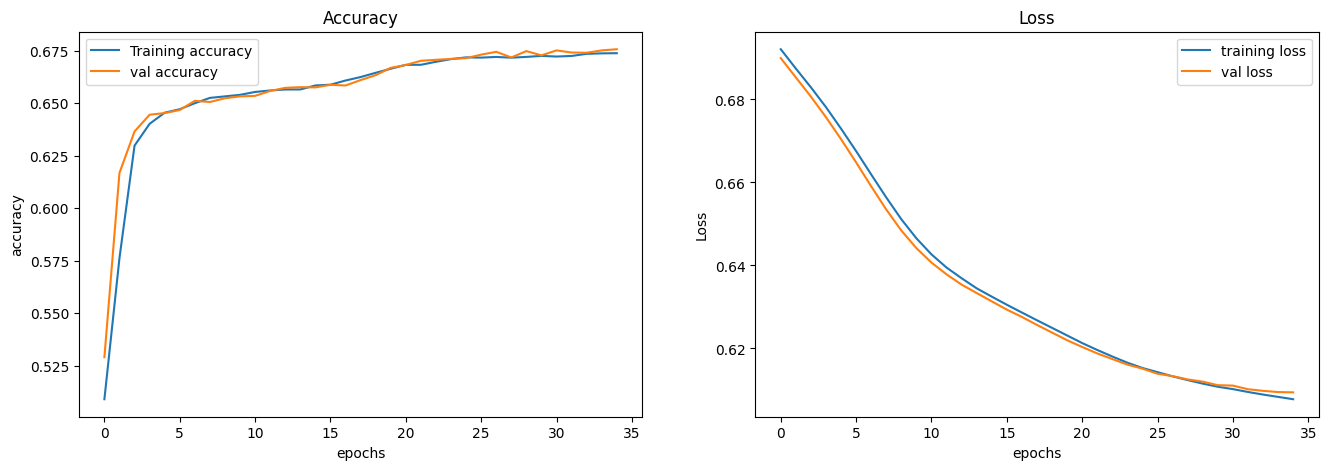

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test.describe()

,rfc_result,rfc_profit_PS,rfc_profit_B365,dtc_abc_result,dtc_abc_profit_PS,dtc_abc_profit_B365,svm_result,svm_profit_PS,svm_profit_B365,vc_result,vc_profit_PS,vc_profit_B365,vc_certainty,svm_certainty,dtc_abc_certainty,rfc_certainty,nn_result,nn_certainty,nn_profit_PS,nn_profit_B365
count,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000
mean,0.669321,-0.000728,-0.033909,0.673808,-0.001260,-0.033808,0.671453,0.002409,-0.031177,0.672686,-0.002118,-0.035446,0.290490,0.346199,0.225669,0.315352,0.675715,0.319412,0.001209,-0.031671
std,0.470484,0.792239,0.813326,0.468845,0.775001,0.800246,0.469711,0.789633,0.810770,0.469259,0.778779,0.800847,0.175533,0.178040,0.156312,0.218165,0.468133,0.158724,0.774993,0.799428
min,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000113,0.000000,0.000033,0.000077,0.000000,0.000050,-1.000000,-1.000000
25%,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.142212,0.200288,0.099909,0.134991,0.000000,0.183439,-1.000000,-1.000000
50%,1.000000,0.206000,0.160000,1.000000,0.210000,0.160000,1.000000,0.210000,0.160000,1.000000,0.210000,0.160000,0.283678,0.379249,0.203654,0.282039,1.000000,0.351930,0.210000,0.160000
75%,1.000000,0.490000,0.440000,1.000000,0.490000,0.440000,1.000000,0.490000,0.440000,1.000000,0.484000,0.440000,0.424911,0.489663,0.323041,0.463684,1.000000,0.465117,0.489000,0.440000
max,1.000000,6.150000,28.000000,1.000000,5.620000,28.000000,1.000000,8.000000,28.000000,1.000000,6.150000,28.000000,0.766462,0.791369,0.761594,0.996098,1.000000,0.529466,6.070000,28.000000


In [20]:
import numpy as np

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

thresholds = np.arange(0.0, .7, .02)
algorithm_list = [("rfc", "random forest"), ("dtc_abc", "decision tree with Ada boost"), ("svm", "support vector machine"), ("vc", "voting"), ("nn", "neural network")]
for alg in algorithm_list:
    thresh_list = []
    profit_rates_PS = []
    profit_rates_B365 = []
    accuracies = []
    for thresh in thresholds:
        weights = 0.0 + (profits_test[f"{alg[0]}_certainty"] >= thresh)
        if weights.mean() > .1:
            thresh_list.append(thresh)
            profit_rates_PS.append(np.average(profits_test[f"{alg[0]}_profit_PS"], weights=weights))
            profit_rates_B365.append(np.average(profits_test[f"{alg[0]}_profit_B365"], weights=weights))
            accuracies.append(np.average(profits_test[f"{alg[0]}_result"], weights=weights))
    # print(len(thresh_list))
    print(f"The best PS performance for {alg[1]} algorithm occurs on the threshold value of {thresh_list[np.array(profit_rates_PS).argmax()]}, with the average profit of {profit_rates_PS[np.array(profit_rates_PS).argmax()]} (on PS) and accuracy of {accuracies[np.array(profit_rates_PS).argmax()]}")

The best PS performance for random forest algorithm occurs on the threshold value of 0.38, with the average profit of 0.020813688212927745 (on PS) and accuracy of 0.8108365019011406
The best PS performance for decision tree with Ada boost algorithm occurs on the threshold value of 0.3, with the average profit of 0.01351260504201679 (on PS) and accuracy of 0.8288770053475936
The best PS performance for support vector machine algorithm occurs on the threshold value of 0.52, with the average profit of 0.030144350097975163 (on PS) and accuracy of 0.8249510124101894
The best PS performance for voting algorithm occurs on the threshold value of 0.4, with the average profit of 0.018036301108139075 (on PS) and accuracy of 0.8356897210546427
The best PS performance for neural network algorithm occurs on the threshold value of 0.06, with the average profit of 0.0018226493127356663 (on PS) and accuracy of 0.6877508818878482


In [21]:
import numpy as np

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

thresholds = np.arange(0.0, .7, .02)
algorithm_list = [("rfc", "random forest"), ("dtc_abc", "decision tree with Ada boost"), ("svm", "support vector machine"), ("vc", "voting"), ("nn", "neural network")]
for alg in algorithm_list:
    thresh_list = []
    profit_rates_PS = []
    profit_rates_B365 = []
    accuracies = []
    for thresh in thresholds:
        weights = 0.0 + (profits_test[f"{alg[0]}_certainty"] >= thresh)
        if weights.mean() > .1:
            thresh_list.append(thresh)
            profit_rates_PS.append(np.average(profits_test[f"{alg[0]}_profit_PS"], weights=weights))
            profit_rates_B365.append(np.average(profits_test[f"{alg[0]}_profit_B365"], weights=weights))
            accuracies.append(np.average(profits_test[f"{alg[0]}_result"], weights=weights))
    # print(len(thresh_list))
    print(f"The best B365 performance for {alg[1]} algorithm occurs on the threshold value of {thresh_list[np.array(profit_rates_B365).argmax()]}, with the average profit of {profit_rates_B365[np.array(profit_rates_B365).argmax()]} (on B365) and accuracy of {accuracies[np.array(profit_rates_B365).argmax()]}")

The best B365 performance for random forest algorithm occurs on the threshold value of 0.62, with the average profit of 0.011344680851063821 (on B365) and accuracy of 0.8840425531914894
The best B365 performance for decision tree with Ada boost algorithm occurs on the threshold value of 0.36, with the average profit of -0.001034258712344959 (on B365) and accuracy of 0.8582398109864147
The best B365 performance for support vector machine algorithm occurs on the threshold value of 0.48, with the average profit of 0.0034985904148207717 (on B365) and accuracy of 0.8091018928715263
The best B365 performance for voting algorithm occurs on the threshold value of 0.52, with the average profit of 0.0064936086529006854 (on B365) and accuracy of 0.8859390363815143
The best B365 performance for neural network algorithm occurs on the threshold value of 0.5, with the average profit of 0.0013513011152416305 (on B365) and accuracy of 0.8680297397769516


In [53]:
import pandas as pd
import numpy as np
import joblib

# Load svm model from disk
model_svm = joblib.load(filename="archive/model_svm.pkl")

# Load random forest model from disk
model_rfc = joblib.load(filename="archive/model_rfc.pkl")

def get_advise(input: dict | pd.DataFrame, platform: str = "PS") -> pd.DataFrame:

    if isinstance(input, dict):
        input = pd.DataFrame(input)

    features_list = [
    "P1_wins_proba_elo",
    "P1_match_count",
    "P2_match_count",
    "P1_pts",
    "P2_pts",
    "field_type==indoor_hard",
    "P1_match_count_indoor_hard",
    "P2_match_count_indoor_hard",
    "P1_wins_proba_elo_indoor_hard",
    "field_type==indoor_carpet",
    "P1_match_count_indoor_carpet",
    "P2_match_count_indoor_carpet",
    "P1_wins_proba_elo_indoor_carpet",
    "field_type==indoor_clay",
    "P1_match_count_indoor_clay",
    "P2_match_count_indoor_clay",
    "P1_wins_proba_elo_indoor_clay",
    "field_type==outdoor_hard",
    "P1_match_count_outdoor_hard",
    "P2_match_count_outdoor_hard",
    "P1_wins_proba_elo_outdoor_hard",
    "field_type==outdoor_clay",
    "P1_match_count_outdoor_clay",
    "P2_match_count_outdoor_clay",
    "P1_wins_proba_elo_outdoor_clay",
    "field_type==outdoor_grass",
    "P1_match_count_outdoor_grass",
    "P2_match_count_outdoor_grass",
    "P1_wins_proba_elo_outdoor_grass",
]

    if set(features_list) - set(input.columns.tolist()):
        raise ValueError(f"wrong input format")

    X = input[features_list]

    if platform == "PS":
        df_result = pd.DataFrame(
            {
                "predict_P1_wins": model_svm.predict(X),
                "certainty": np.absolute(2 * model_svm.predict_proba(X)[:, 1] - 1.0),
            },
            index=X.index,
        )
        df_result["advise"] = df_result["predict_P1_wins"].replace(
            {True: "P1", False: "P2"}
        )
        df_result.loc[df_result["certainty"] < 0.52, "advise"] = np.nan
        return df_result[["advise", "predict_P1_wins", "certainty"]]
    elif platform == "B365":
        df_result = pd.DataFrame(
            {
                "predic_P1_wins": model_rfc.predict(X),
                "certainty": np.absolute(2 * model_rfc.predict_proba(X)[:, 1] - 1.0),
            },
            index=X.index,
        )
        df_result["advise"] = df_result["predict_P1_wins"].replace(
            {True: "P1", False: "P2"}
        )
        df_result.loc[df_result["certainty"] < 0.62, "advise"] = np.nan
        return df_result[["advise", "predict_P1_wins", "certainty"]]
    else:
        raise ValueError(f'Unkown platform "{platform}"')

    
advise_test = get_advise(X_test)

In [54]:
print(f"This function advises to bet on {round(100.0*(1.0 - advise_test['advise'].isna().sum()/len(advise_test)), 2)} % of matches")
advise_test.head()

This function advises to bet on 17.17 % of matches


,advise,predict_P1_wins,certainty
11353,NaN,True,0.233578
28181,NaN,False,0.110837
49823,NaN,False,0.442044
42435,NaN,True,0.063614
16501,NaN,True,0.129426
